In [2]:
# !pip3 install two-sample-binomial
# !pip3 install multiple-hypothesis-testing

from multitest import MultiTest

import numpy as np
import scipy

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize'] =  [8, 6]
mpl.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm
import pandas as pd

from survival import *

from test_gene_expression import reduce_time_resolution
from illustrate_gene_expression_survival_curves import illustrate_survival_curve_time2event

## Load raw data:

In [2]:
df = pd.read_csv("./Data/SCANB_groups_valid.csv")
gene_names = [c for c in df.columns if c not in ['Unnamed: 0', 'time', 'event']]

div_probs = df.agg(['mean'])
thresh = 0.001
valid_genes = [g for g in gene_names if np.abs(div_probs[g]['mean'] - 0.5) < thresh]
invalid_genes = [g for g in gene_names if np.abs(div_probs[g]['mean'] - 0.5) > thresh]
df = df.drop(columns = invalid_genes + ['Unnamed: 0'])

assert(len(invalid_genes) == 0)

print("Removed: ", 9259 - len(valid_genes))

Removed:  557


### Ilustrate data raw data

HERE (5/9/2023):
 - finish survival curve with lifeline
 - check what is the issue with our implementation

(0.7, 1.01)

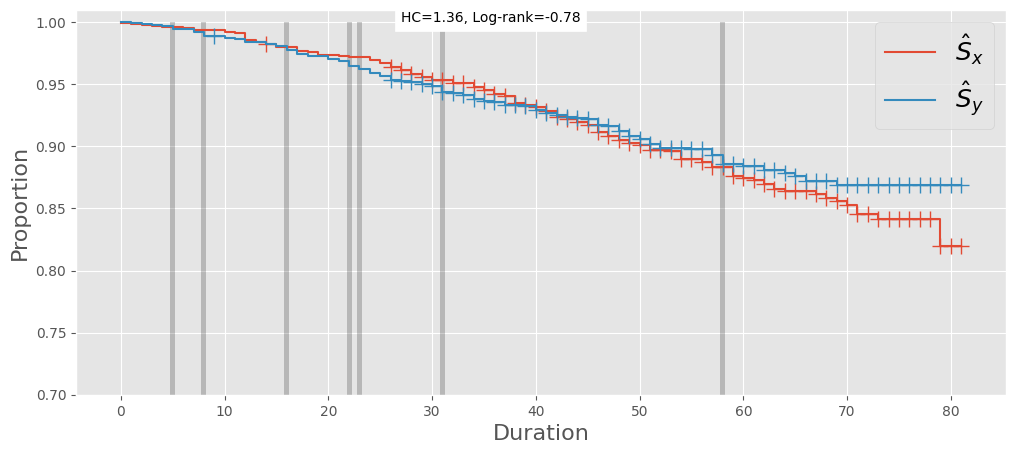

In [3]:
plt.rcParams['figure.figsize'] =  [12, 5]

gene_name = 'IFNAR2'

df_gene = df.filter([gene_name, 'time', 'event'])
df_gene_T = reduce_time_resolution(df_gene, T=82)
illustrate_survival_curve_time2event(df_gene_T.rename(columns={gene_name : 'group'}))
plt.ylim([0.7,1.01])

## Read and report null values

In [3]:
def infmean(x):
    "mean ignoring inf values"
    return np.mean(np.ma.masked_invalid(x))

def std_95(x):
    return scipy.stats.mstats.mjci(x, prob = [0.95])[0]

def q95(x):
    """
    Compute the 95-th percentile of the vector x
    """
    if x.dtypes.kind == 'O':
        return np.nan
    else:
        return pd.Series.quantile(x, .95)

def q99(x):
    """
    Compute the 95-th percentile of the vector x
    """
    if x.dtypes.kind == 'O':
        return np.nan
    else:
        return pd.Series.quantile(x, .99)


def infstd(x):
    return np.std(np.ma.masked_invalid(x))


In [11]:
T = 82
M = 1
stbl = True
from glob import glob

lo_files = glob("results/SCANB_null_True_T82_rep*.csv")
print(lo_files)
df0 = pd.concat([pd.read_csv(f) for f in lo_files])
a = df0.filter(['hc_greater', 'log_rank_greater', 'log_rank_pval_greater', 'hc_greater_rev', 'logrank_lifelines_None']).agg(['mean','std',q95, q99])
crit_vals = a.loc['q95'].to_dict()
a

['results/SCANB_null_True_T82_rep1_202309111525.csv', 'results/SCANB_null_True_T82_rep1_202309111144.csv', 'results/SCANB_null_True_T82_rep1_202309111157.csv', 'results/SCANB_null_True_T82_rep1_202309122025.csv']


,hc_greater,log_rank_greater,log_rank_pval_greater,hc_greater_rev,logrank_lifelines_None
mean,-1.037163,-0.004043,0.501127,-1.034616,1.002143
std,1.206160,1.001017,0.289538,1.212845,1.402582
q95,0.635334,1.644612,0.949515,0.632867,3.833627
q99,0.956069,2.309313,0.989995,0.955485,6.589714


In [5]:
output_dir = "/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/"
#output_dir = "./"

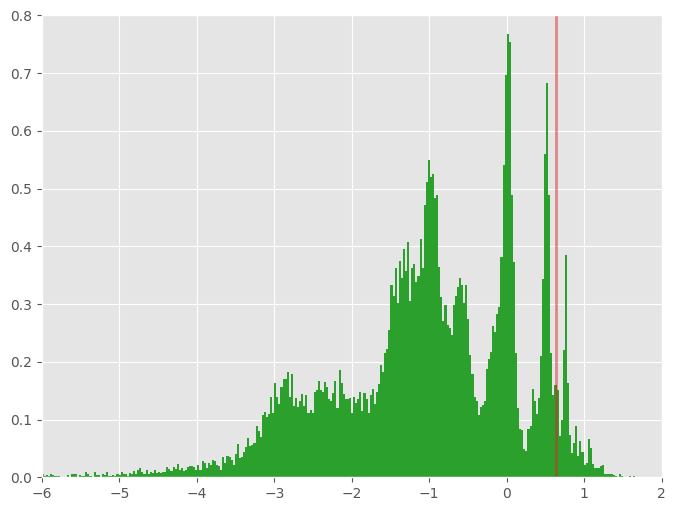

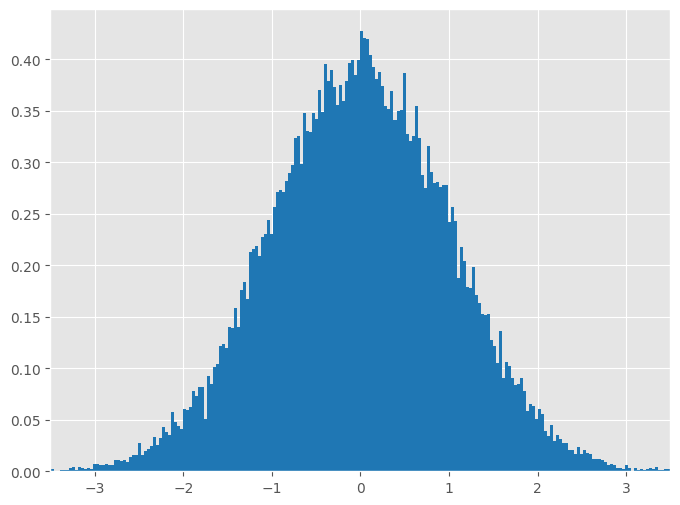

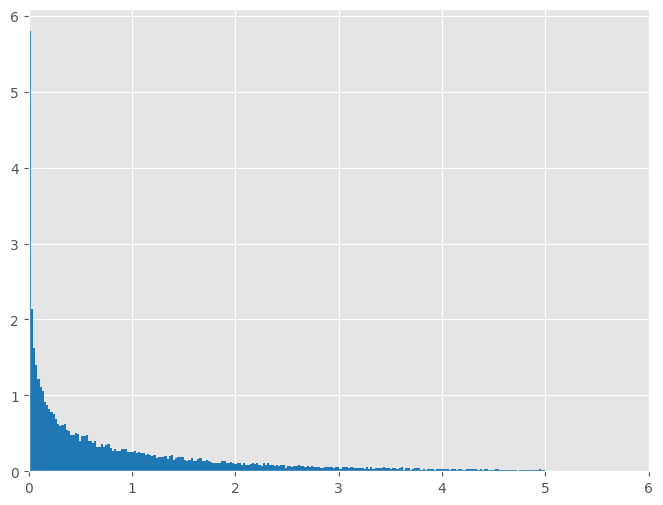

In [9]:
vals = list(df0.hc_greater)
plt.hist(vals, bins = np.linspace(-6,3,337), density=True, color='tab:green')
plt.rcParams['figure.figsize'] =  [8, 6]
plt.xlim([-6, 2])
plt.ylim([0, 0.8])
plt.vlines(crit_vals['hc_greater'], 0, 1, linewidth=2, color='tab:red', alpha=0.5, label='99% quantile')
#plt.text(crit_vals['hc_greater'] - 0.5, 0.45, "99% quantile", color='tab:red', backgroundcolor='white')

plt.savefig(output_dir + f'Figs/hc_hist_T{T}.png', dpi=180, bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

vals = list(df0.log_rank_greater) 
plt.hist(vals, bins = np.linspace(-4,4,237), density=True, color='tab:blue')
plt.rcParams['figure.figsize'] =  [8, 6]
plt.xlim([-3.5, 3.5])

plt.savefig(output_dir + 'Figs/lr_hist.png',dpi=180, bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

vals = list(df0.logrank_lifelines_None) 
plt.hist(vals, bins = np.linspace(0,5,237), density=True, color='tab:blue')
plt.rcParams['figure.figsize'] =  [8, 6]
plt.xlim([0, 6])

plt.savefig(output_dir + 'Figs/lr_chisq_hist.png', dpi=180, bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

## Analyze Results

Use script in ``test_gene_expression.py`` to get the results

In [13]:
result_file = "results/SCANB_True_T82.csv"
null_file = "results/SCANB_null_True_T82_rep1_202309111525.csv"

res = pd.read_csv(result_file)
df0 = pd.read_csv(null_file)

a = df0.filter(['hc_greater', 'log_rank_greater', 'log_rank_pval_greater', 'hc_greater_rev', 'logrank_lifelines_None']).agg(['mean','std',q95, q99])
crit_vals = a.loc['q99'].to_dict()
a

,hc_greater,log_rank_greater,log_rank_pval_greater,hc_greater_rev,logrank_lifelines_None
mean,-1.046249,-0.011986,0.504324,-1.031951,0.999600
std,1.200630,0.999729,0.289413,1.221426,1.388952
q95,0.617137,1.649421,0.948128,0.638593,3.862069
q99,0.944875,2.315380,0.989704,0.978599,6.588223


In [14]:
# logrank_lifeline is chisquared with 1 dof
print("var: ", df0['logrank_lifelines_None'].var())
print("std: ", df0['logrank_lifelines_None'].std())
print("mean: ", df0['logrank_lifelines_None'].mean())
print("q95: ", df0['logrank_lifelines_None'].quantile(.95))

from scipy.stats import chi2
chi2.isf(0.05, 1)
chi2.moment(df=1, order=1)

var:  1.9291868418461404
std:  1.3889517060884948
mean:  0.9995998171169548
q95:  3.8620688241979617


1.0

In [15]:
STATS = ['hc_greater', 'hc_greater_rev', 'log_rank_greater', 'log_rank_greater_rev',
         'logrank_lifelines_None', 'logrank_lifelines_None_rev',
        'logrank_lifelines_wilcoxon', 'logrank_lifelines_wilcoxon_rev',
        'logrank_lifelines_tarone-ware', 'logrank_lifelines_tarone-ware_rev',
        'logrank_lifelines_peto', 'logrank_lifelines_peto_rev',
        'logrank_lifelines_fleming-harrington01', 'logrank_lifelines_fleming-harrington01_rev',
        'logrank_lifelines_fleming-harrington10', 'logrank_lifelines_fleming-harrington10_rev'
        ]


NAME_NEAT = {'hc_greater': "HCHG",
             'log_rank_greater': 'Log-rank',
        'logrank_lifelines_fleming-harrington01': 'Fleming-Harrington01',
        'logrank_lifelines_fleming-harrington01_rev': 'Fleming-Harrington01',
       'logrank_lifelines_fleming-harrington10': 'Fleming-Harrington10',
       'logrank_lifelines_fleming-harrington10_rev': 'Fleming-Harrington10',
       'logrank_lifelines_tarone-ware': 'Tarone-Ware',
       'logrank_lifelines_tarone-ware_rev': 'Tarone-Ware',
        'logrank_lifelines_peto': 'Peto',
        'logrank_lifelines_peto_rev': 'Peto',
        'logrank_lifelines_wilcoxon': 'Wilcoxon',
        'logrank_lifelines_wilcoxon_rev': 'Wilcoxon',
        'others': 'Others'
        }

COLOR_LIST = ["tab:red", "tab:blue", "tab:orange", "tab:purple", "tab:brown", "tab:pink", "tab:cyan", "tab:green"]
COLOR_LIST_STATS = {'HCHG': 'tab:red',
                    'Log-rank': 'tab:blue',
                    'Fleming-Harrington01': 'tab:orange',
                    'Fleming-Harrington10': 'tab:orange',
                    'Tarone-Ware': 'tab:purple',
                    'Peto': 'tab:brown',
                    'Wilcoxon': 'tab:pink',
                    'Others': 'tab:pink',
                    }
                    

In [16]:
def get_discoverable_by_statistic(res:pd.DataFrame, stat, sig_level, side='either'):
    
    if f'{stat}_pvalue' not in res.columns:
        logging.error(f"{stat} not found in results.")
        exit(1)

    if side == 'either':
        a = (res[f'{stat}_pvalue'] <= sig_level)
        if f'{stat}_rev_pvalue' in res.columns:
            a = a | (res[f'{stat}_rev_pvalue'] <= sig_level)
        return a
    
    if side == 'strict':
        if f'{stat}_rev_pvalue' in res.columns:    
            a = (res[f'{stat}_pvalue'] <= sig_level) & (res[f'{stat}_rev_pvalue'] > sig_level)
            b = (res[f'{stat}_pvalue'] > sig_level) & (res[f'{stat}_rev_pvalue'] <= sig_level)
            return a | b
        else:
            return res[f'{stat}_pvalue'] <= sig_level
    if side == 'greater':
        return (res[f'{stat}_pvalue'] <= sig_level)
    if side == 'less':
        return (res[f'{stat}_rev_pvalue'] <= sig_level)

def get_discoverable_by_many_statistics(res:pd.DataFrame, stat_list, sig_level, side='either'):
        "Return an indicator vector of genes discoverable by many statistics"
        discoverable_list = np.array([False] * len(res))
        for stat in stat_list:
            discoverable_list  = discoverable_list | get_discoverable_by_statistic(res, stat, sig_level, side=side) 
        return discoverable_list
     

In [17]:
def find_pvalues_of_stats_results(df1, df0, stat_name):
    val0 =df0[stat_name]
    def stat0(x):
        return np.mean(val0 > x)

    return df1[stat_name].apply(stat0)

for stat_name in STATS:
    res.loc[:, stat_name + '_pvalue'] = find_pvalues_of_stats_results(res, df0, stat_name)

In [18]:
results = []
sig_levels = [0.05, 0.01, 0.001, 0.0001]
for sig_level in sig_levels:
    for stn in STATS:
        if "_rev" not in stn:
            sig = sig_level
            nod = np.sum( get_discoverable_by_statistic(res, stn, sig_level=sig, side='either') )
            results.append({'sig_level': sig_level, 'number of discoveries': nod, 'stat_name': stn})

pd.DataFrame(results)


,sig_level,number of discoveries,stat_name
0,0.0500,2151,hc_greater
1,0.0500,4616,log_rank_greater
2,0.0500,3890,logrank_lifelines_None
3,0.0500,4097,logrank_lifelines_wilcoxon
4,0.0500,4036,logrank_lifelines_tarone-ware
5,0.0500,3935,logrank_lifelines_peto
6,0.0500,2490,logrank_lifelines_fleming-harrington01
7,0.0500,3935,logrank_lifelines_fleming-harrington10
8,0.0100,1016,hc_greater
9,0.0100,3174,log_rank_greater


In [19]:
sig_level = 0.05
log_rank_non = (res[f'log_rank_greater_pvalue'] > sig_level) & (res[f'log_rank_greater_rev_pvalue'] > sig_level)
log_rank_1side_strict = get_discoverable_by_statistic(res, 'log_rank_greater', sig_level, side='strict')
log_rank_1side_either = get_discoverable_by_statistic(res, 'log_rank_greater', sig_level, side='either')

hc_non = (res['hc_greater_pvalue'] > sig_level) & (res['hc_greater_rev_pvalue'] > sig_level)
hc_1side_strict = get_discoverable_by_statistic(res, 'hc_greater', sig_level, side='strict')
hc_1side_either = get_discoverable_by_statistic(res, 'hc_greater', sig_level, side='either')


print("Strictly one-sided effect:")
print("\tDiscoverable by HCHG: ", np.sum(hc_1side_strict))
print(f"\tDiscoverable by LR: ", np.sum(log_rank_1side_strict))

print(f"\tDiscoverable by HCHG and LR: ", np.sum(hc_1side_strict & log_rank_1side_strict))
print(f"\tDiscoverable by HCHG but not LR: ", np.sum(hc_1side_strict & (~log_rank_1side_strict) )   )
print(f"\tDiscoverable by LR but not HCHG: ", np.sum((~hc_1side_strict) & ( log_rank_1side_strict) )   )
print(f"\tDiscoverable by neigher HCHG nor LR: ", np.sum((~hc_1side_strict) & (~log_rank_1side_strict) )   )

print(" Either side effect:")

print("\tDiscoverable by HCHG: ", np.sum(hc_1side_either))
print(f"\tDiscoverable by LR: ", np.sum(log_rank_1side_either))


print(f"\tDiscoverable by HCHG and LR: ", np.sum(hc_1side_either & log_rank_1side_either))
print(f"\tDiscoverable by HCHG but not LR: ", np.sum(hc_1side_either & (~log_rank_1side_either) )   )
print(f"\tDiscoverable by LR but not HCHG: ", np.sum((~hc_1side_either) & ( log_rank_1side_either) )   )
print(f"\tDiscoverable by neigher HCHG nor LR: ", np.sum((~hc_1side_either) & (~log_rank_1side_either) )   )

# all stats except HC
STATS_no_HC = [s for s in STATS if 'hc_' not in s]
all_two_sided = get_discoverable_by_many_statistics(res, STATS_no_HC, sig_level, side='either')

print("All stats except HC (Either side effect):")
print(f"\tDiscoverable by all others: ", np.sum(all_two_sided))
print("HCHG but not others (Either side effect):")
print(f"\tDiscoverable by HCHG but not by any other: ", np.sum(hc_1side_either & (~all_two_sided)))

# print venn diagrams


Strictly one-sided effect:
	Discoverable by HCHG:  2135
	Discoverable by LR:  4616
	Discoverable by HCHG and LR:  1738
	Discoverable by HCHG but not LR:  397
	Discoverable by LR but not HCHG:  2878
	Discoverable by neigher HCHG nor LR:  3689
 Either side effect:
	Discoverable by HCHG:  2151
	Discoverable by LR:  4616
	Discoverable by HCHG and LR:  1742
	Discoverable by HCHG but not LR:  409
	Discoverable by LR but not HCHG:  2874
	Discoverable by neigher HCHG nor LR:  3677
All stats except HC (Either side effect):
	Discoverable by all others:  4835
HCHG but not others (Either side effect):
	Discoverable by HCHG but not by any other:  362


In [20]:
from matplotlib_venn import venn2, venn3

def plot_venn2(set_dict):
    sets = [set_dict[k] for k in set_dict]
    labels = [NAME_NEAT[k] for k in set_dict]
    colors = [COLOR_LIST_STATS[l] for l in labels]
    v = venn2(sets, set_labels = labels, set_colors=colors)

    for i,ch in enumerate('AB'):
        lb = v.get_label_by_id(ch)
        lb.set_color(COLOR_LIST_STATS[labels[i]])
        lb.set_fontsize(20)
    
    for ch in ['10', '01', '11']:
        v.get_label_by_id(ch).set_fontsize(16)
    plt.show()


def plot_venn3(set_dict):
    sets = [set_dict[k] for k in set_dict]
    labels = [NAME_NEAT[k] for k in set_dict]
    colors = [COLOR_LIST_STATS[l] for l in labels]
    v = venn3(sets, set_labels = labels, set_colors=colors)

    for i,ch in enumerate('ABC'):
        lb = v.get_label_by_id(ch)
        lb.set_color(COLOR_LIST_STATS[labels[i]])
        lb.set_fontsize(20)
    
    for ch in ['100', '010', '001', '011', '111']:
        v.get_label_by_id(ch).set_fontsize(16)
    plt.show()


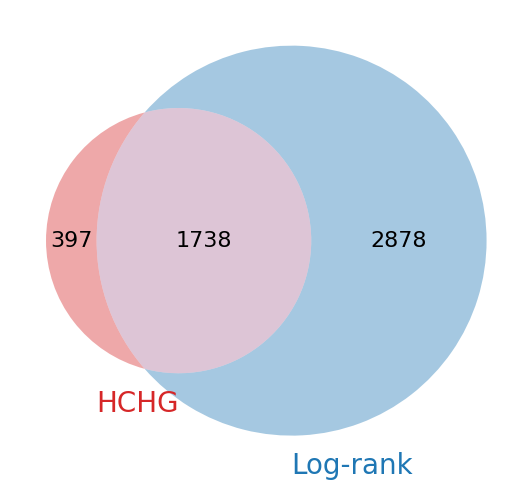

<Figure size 800x600 with 0 Axes>

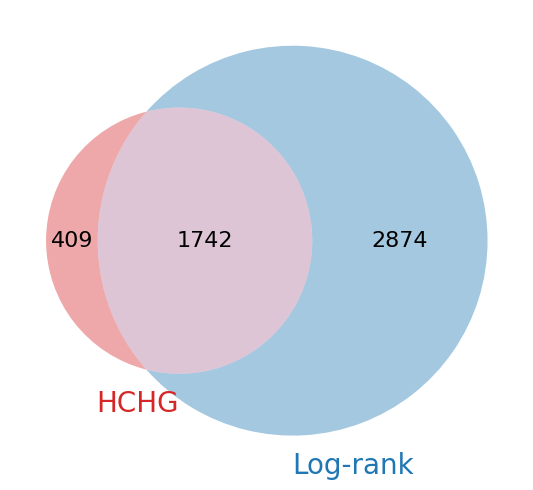

<Figure size 800x600 with 0 Axes>

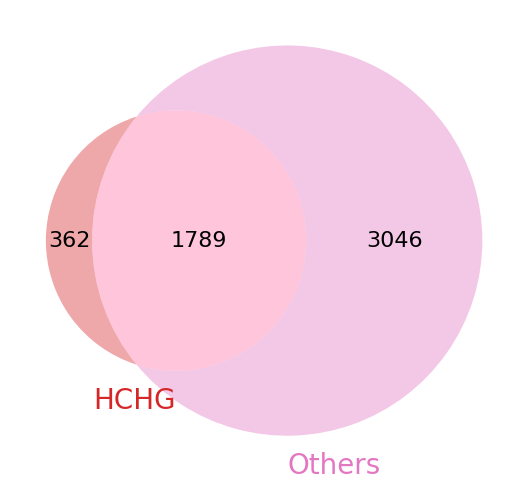

<Figure size 800x600 with 0 Axes>

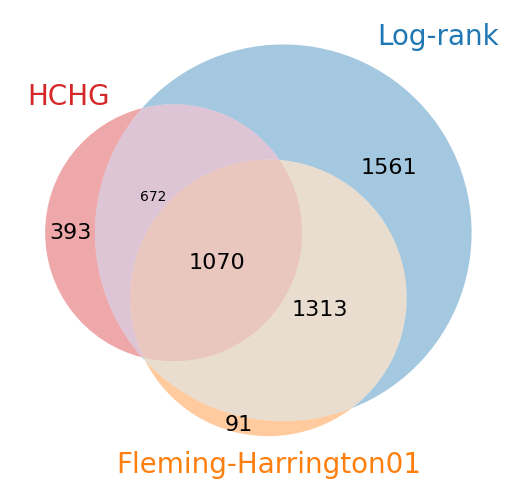

<Figure size 800x600 with 0 Axes>

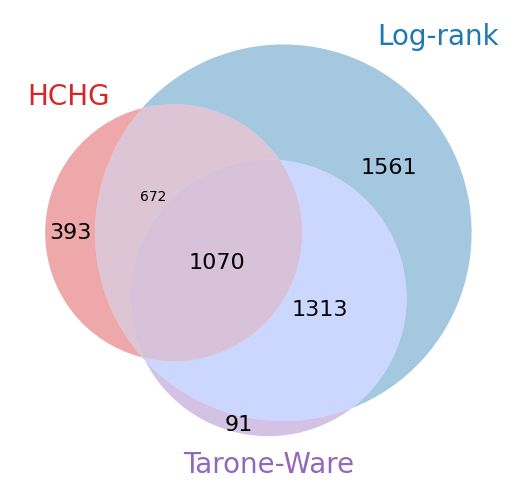

<Figure size 800x600 with 0 Axes>

In [21]:
names = res['name']
s1 = set(names[get_discoverable_by_statistic(res, 'hc_greater', sig_level, side='strict')])
s2 = set(names[get_discoverable_by_statistic(res, 'log_rank_greater', sig_level, side='strict')])
plot_venn2({'hc_greater': s1, 'log_rank_greater': s2})
plt.savefig(output_dir + "venn_HCHG_LR_strict.png",transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()

# either side one-sided

s1 = set(names[get_discoverable_by_statistic(res, 'hc_greater', sig_level, side='either')])
s2 = set(names[get_discoverable_by_statistic(res, 'log_rank_greater', sig_level, side='either')])
plot_venn2({'hc_greater': s1, 'log_rank_greater': s2})
plt.savefig(output_dir + "venn_HCHG_LR_either.png",transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()


# all others
STATS_no_HC = [s for s in STATS if 'hc_' not in s]
s1 = set(names[get_discoverable_by_statistic(res, 'hc_greater', sig_level, side='either')])
s2 = set(names[get_discoverable_by_many_statistics(res, STATS_no_HC, sig_level, side='either')])

plot_venn2({'hc_greater': s1, 'others': s2})

plt.savefig(output_dir + "venn_HCHG_others_either.png",transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()



s1 = set(names[get_discoverable_by_statistic(res, 'hc_greater', sig_level, side='either')])
s2 = set(names[get_discoverable_by_statistic(res, 'log_rank_greater', sig_level, side='either')])
s3 = set(names[get_discoverable_by_statistic(res, 'logrank_lifelines_fleming-harrington01', sig_level, side='either')])

plot_venn3({'hc_greater': s1,
            'log_rank_greater': s2,
            'logrank_lifelines_fleming-harrington01': s3
            })

plt.savefig(output_dir + "venn_others_either_side1.png",transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()

s1 = set(names[get_discoverable_by_statistic(res, 'hc_greater', sig_level, side='either')])
s2 = set(names[get_discoverable_by_statistic(res, 'log_rank_greater', sig_level, side='either')])
s3 = set(names[get_discoverable_by_statistic(res, 'logrank_lifelines_fleming-harrington01', sig_level, side='either')])

plot_venn3({'hc_greater': s1,
            'log_rank_greater': s2,
            'logrank_lifelines_tarone-ware': s3
            })

plt.savefig(output_dir + "venn_others_either_side2.png",transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()


### Arrange Results for presentation:

In [23]:
from analyze_gene_expression_results import STATS_TO_DISPLAY
from illustrate_gene_expression_survival_curves import illustrate_survival_curve_gene

In [24]:
res['hc_pval'] = np.minimum(res['hc_greater_pvalue'], res['hc_greater_rev_pvalue'])
res['log_rank_pval'] = np.minimum(res['log_rank_greater_pvalue'], res['log_rank_greater_rev_pvalue'])
res['l-ratio'] = res['hc_pval'] / res['log_rank_pval']

In [25]:
# take only those discovered by HC but not any other
resi = res[~get_discoverable_by_many_statistics(res, STATS_no_HC, sig_level, side='either')]
resi = resi.sort_values('l-ratio')
resi.head(n=20).name.values

array(['PBX1', 'PMS2', 'DHX32', 'CLCF1', 'MGAT4A', 'DDX5', 'SLC5A12',
       'MRAS', 'RARRES1', 'IFNAR2', 'EPB41L4B', 'CHST2', 'LDHB', 'TLX2',
       'CYTH1', 'RCAN1', 'SIPA1', 'MALL', 'CERS2', 'SLC16A2'],
      dtype=object)

In [49]:
def prepare_for_display(resi):
    flip_idc = resi['hc_greater'] < resi['hc_greater_rev']
    resi['flip'] = '$>$ med'
    resi.loc[flip_idc, 'flip'] = '$<$ med'
    resi['hc'] = np.maximum(resi['hc_greater'], resi['hc_greater_rev'])
    resi['log_rank'] = np.maximum(resi['log_rank_greater'], resi['log_rank_greater_rev'])
    resi['hc_pvalue'] = np.minimum(resi['hc_greater_pvalue'], resi['hc_greater_rev_pvalue'])
    resi['log_rank_pvalue'] = np.minimum(resi['log_rank_greater_pvalue'], resi['log_rank_greater_rev_pvalue'])
    rr = resi.reset_index()#.filter(['name', 'hc', 'hc_pvalue', 'log_rank', 'log_rank_pvalue', 'flip'])
    return rr

resi_disp = prepare_for_display(resi)

ls = resi_disp.name.head(70).tolist()
print("Num = ", len(ls))
ls


Num =  70


['PBX1',
 'PMS2',
 'DHX32',
 'CLCF1',
 'MGAT4A',
 'DDX5',
 'SLC5A12',
 'MRAS',
 'RARRES1',
 'IFNAR2',
 'EPB41L4B',
 'CHST2',
 'LDHB',
 'TLX2',
 'CYTH1',
 'RCAN1',
 'SIPA1',
 'MALL',
 'CERS2',
 'SLC16A2',
 'ANKLE2',
 'CYFIP2',
 'MAP4K2',
 'PRAF2',
 'FHL2',
 'SRP54',
 'ENTPD3',
 'ATAT1',
 'ARPC4',
 'PAIP2B',
 'FAM20B',
 'MBD3',
 'MNS1',
 'MATK',
 'CRADD',
 'TM9SF3',
 'TARBP1',
 'ATP6AP1',
 'VASH2',
 'WNT6',
 'TMCO1',
 'POGLUT1',
 'RGS17',
 'RPS7',
 'RECQL5',
 'MICAL1',
 'CASS4',
 'KLHL12',
 'CCL13',
 'MRPS2',
 'VGLL1',
 'CCDC88A',
 'OBP2A',
 'RNF122',
 'ARR3',
 'FAM120C',
 'CENPJ',
 'DOK4',
 'GGTLC2',
 'EPHX1',
 'BAZ1A',
 'RRH',
 'DNAJC13',
 'EIF2B4',
 'DOC2A',
 'SLCO3A1',
 'IL10RB',
 'RNF39',
 'FHL3',
 'CYB5R3']

#### Illustrate gene and intervals of excessive hazard

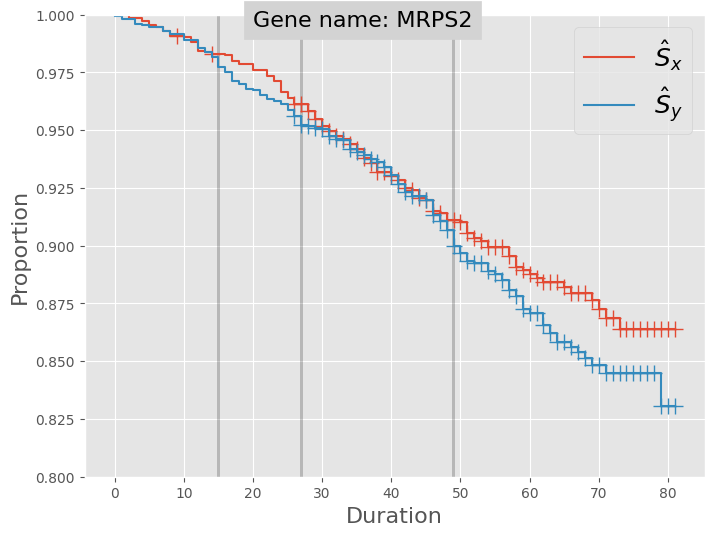

In [61]:
illustrate_survival_curve_gene(df, "MRPS2", T=82)
plt.ylim([0.8,1])
plt.show()

INFO:root:Flipped sides


Saved figure to Figs/FAM20B_survival.png.


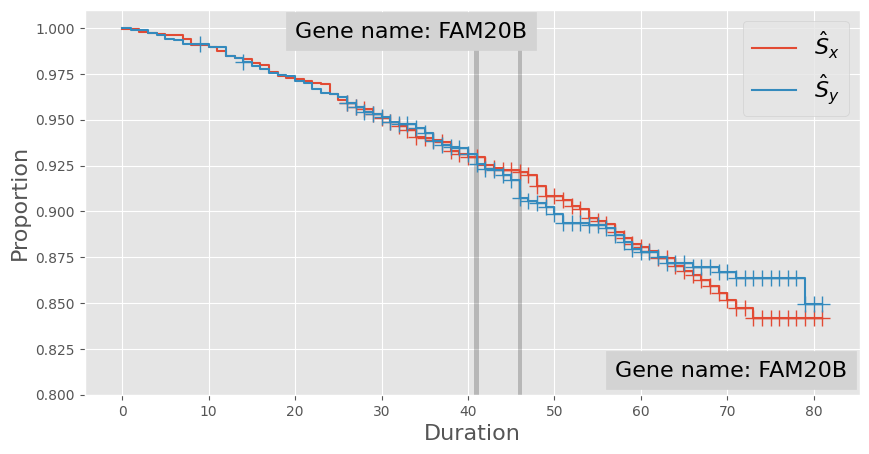

INFO:root:Flipped sides


Saved figure to Figs/PBX1_survival.png.


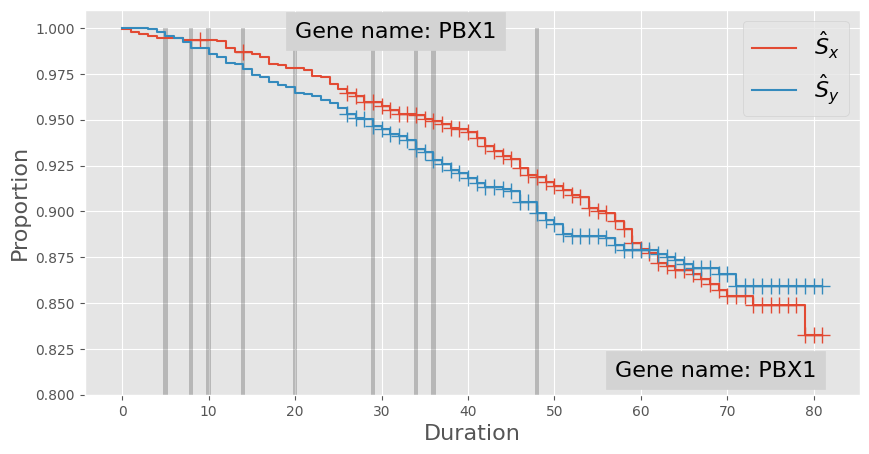

INFO:root:Flipped sides


Saved figure to Figs/CRADD_survival.png.


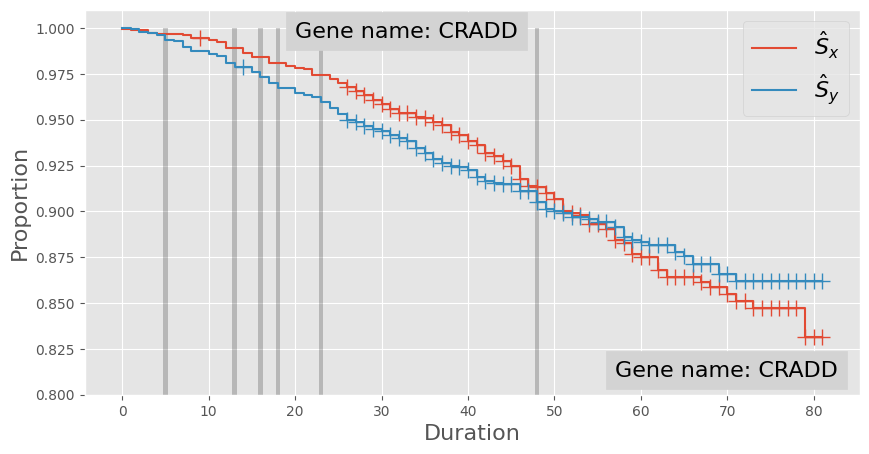

Saved figure to Figs/MBD3_survival.png.


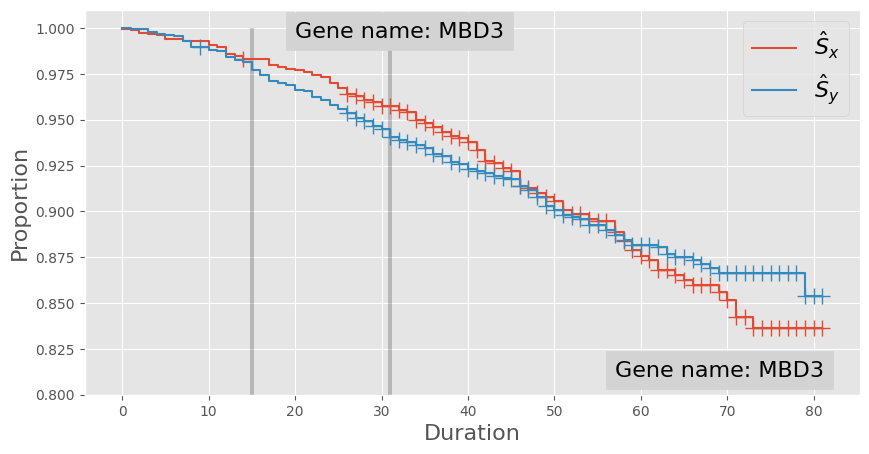

Saved figure to Figs/EPB41L4B_survival.png.


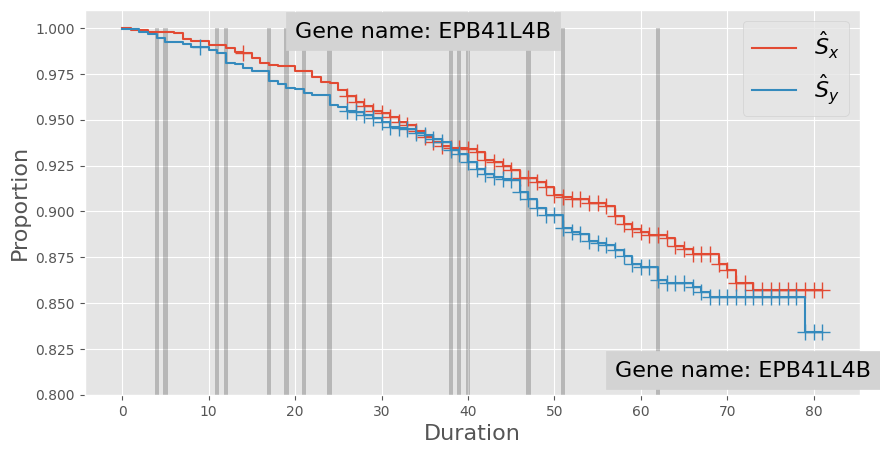

INFO:root:Flipped sides


Saved figure to Figs/ANKLE2_survival.png.


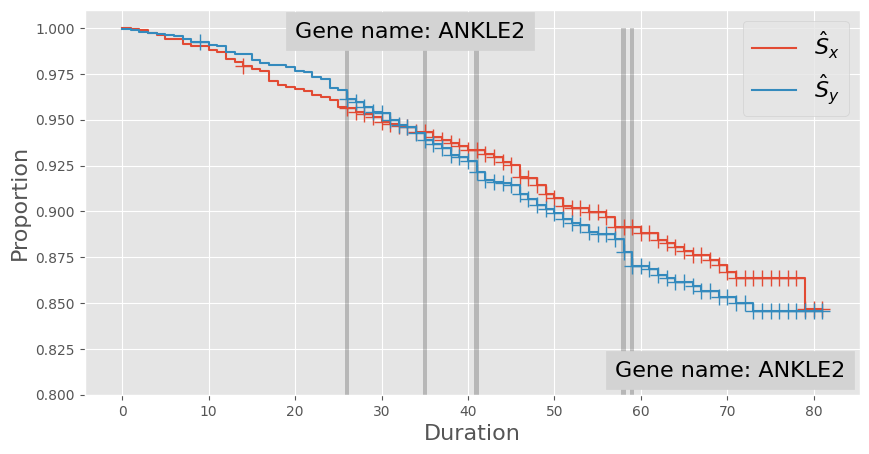

INFO:root:Flipped sides


Saved figure to Figs/DDX5_survival.png.


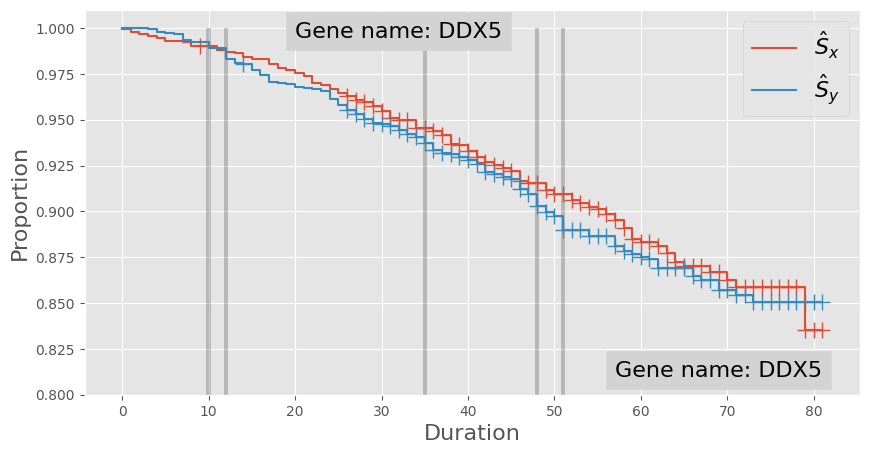

Saved figure to Figs/MRAS_survival.png.


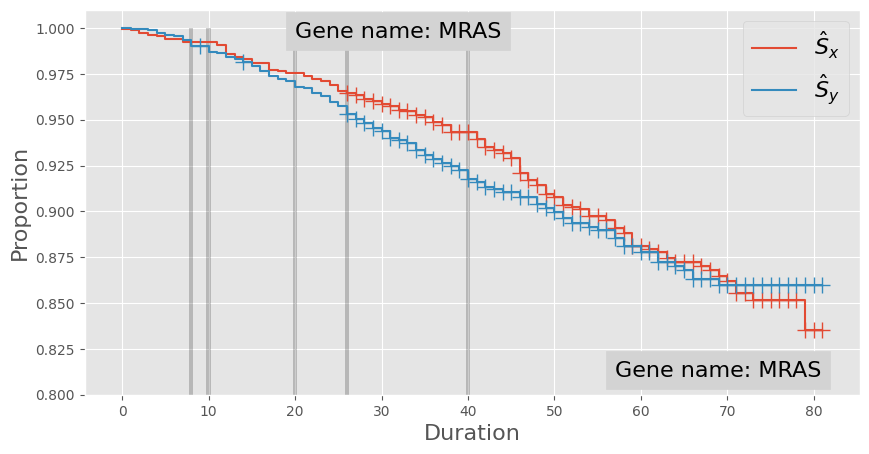

INFO:root:Flipped sides


Saved figure to Figs/CLCF1_survival.png.


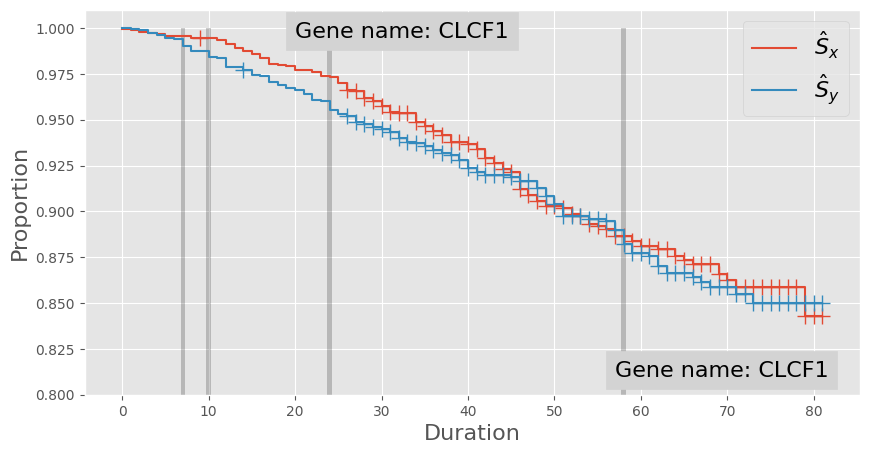

Saved figure to Figs/MALL_survival.png.


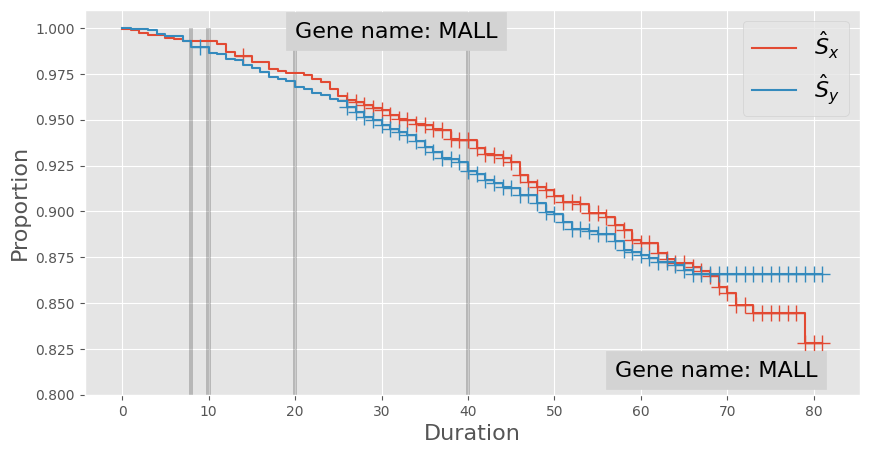

In [47]:
from analyze_gene_expression_results import SELECTED_GENES, get_pvals_for_gene
SELECTED_GENES = ['FAM20B', 'PBX1', 'CRADD', 'MBD3', 'EPB41L4B', 'ANKLE2', 'DDX5', 'MRAS', 'CLCF1', 'MALL']

OUTPUT_DIR_FIGS = "Figs"
#OUTPUT_DIR_CSV = "/Users/kipnisal/Dropbox/Apps/Overleaf/Survival Analysis with Sensitivity to Possible Rare and Weak Differences/csv"
OUTPUT_DIR_CSV = "csv"

for gene_name in SELECTED_GENES:
    plt.figure(figsize=(10, 5))
    _, df_HCT = illustrate_survival_curve_gene(df, gene_name, T)
    plt.text(int(T - 25), .81, f"Gene name: {gene_name}", backgroundcolor='lightgray', fontsize=16)
    plt.legend(loc='upper right', fontsize=16)
    plt.ylim([0.8, 1.01])

    fig_filename = OUTPUT_DIR_FIGS + f"/{gene_name}.png"
    plt.savefig(fig_filename, dpi=300, bbox_inches='tight', pad_inches=0.05)
    print(f"Saved figure to {fig_filename}.")
    plt.show()
    df_HCT.to_csv(f"{OUTPUT_DIR_CSV}/{gene_name}_HCT.csv")

    #df_pvals = get_pvals_for_gene(resi_disp, gene_name)
    #df_pvals.to_csv(f"{output_dir}csv/{gene_name}_pvals.csv")
    

#### Todo: 
- Fix the functions below to include all information for testing; use the lifeline notation

,removed:0,removed:1,observed Y,observed X,censored:1,censored:0,at_risk Y,at_risk X,pvalue,pvalue_rev
event_at,,,,,,,,,,
7.0,6.0,0.0,6.0,0.0,0.0,0.0,1527.0,1526.0,0.015579,1.0
8.0,5.0,0.0,5.0,0.0,0.0,0.0,1521.0,1526.0,0.030892,1.0
10.0,5.0,0.0,5.0,0.0,0.0,0.0,1516.0,1525.0,0.030688,1.0
20.0,5.0,0.0,5.0,0.0,0.0,0.0,1488.0,1497.0,0.030678,1.0
29.0,19.0,16.0,6.0,0.0,13.0,16.0,1406.0,1414.0,0.015279,1.0


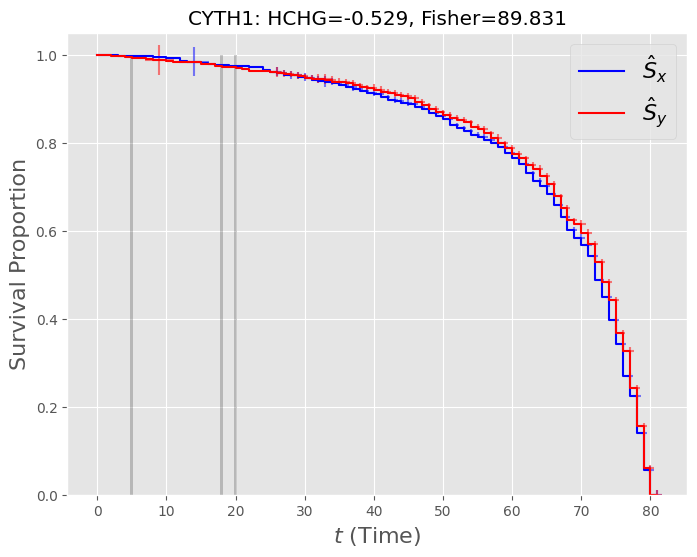

In [183]:
def HCHG_survival_analysis(Nt1, Nt2, Ot1, Ot2, randomize=False, stbl=stbl):

    pvals = multi_pvals(Nt1, Nt2, Ot1, Ot2, randomize=randomize)
    mt = MultiTest(pvals[pvals<1], stbl=stbl) 
    hc, hct = mt.hc(gamma=.2)
    fisher = mt.fisher()
        
    fpval = pvals <= hct
    
    dfg['pvalue'] = pvals
    dfg['t'] = np.arange(0,len(Ot1))

    cumc1 = dfg['censored:0'].cumsum()
    cumc2 = dfg['censored:1'].cumsum()
    dfg['Survival Proportion X'] = (dfg['at_risk:0'] - dfg['censored:0']) / (dfg['at_risk:0'].max() - cumc1)
    dfg['Survival Proportion Y'] = (dfg['at_risk:1'] - dfg['censored:1']) / (dfg['at_risk:1'].max() - cumc2)
        
    dfg['suspected'] = fpval
    return dfg.set_index('t'), hc, fisher[0]

def HCHG_survival_analysis_full(Nt1, Nt2, Ot1, Ot2, randomize=False, stbl=stbl):
    
    dfg, hc, fisher = HCHG_survival_analysis(Nt1, Nt2, Ot1, Ot2, randomize=randomize, stbl=stbl)
    
    fpval = dfg.suspected
    plt.step(dfg.index, dfg['Survival Proportion X'], 'b', where='pre')
    plt.step(dfg.index, dfg['Survival Proportion Y'], 'r', where='pre')
    ct1 = dfg['censored:0'] > 0
    ct2 = dfg['censored:1'] > 0
    s1 = 10 * (dfg.loc[ct1, 'censored:0'].max() / dfg.loc[ct1, 'censored:0']).values
    s2 = 10 * (dfg.loc[ct2, 'censored:1'].max() / dfg.loc[ct2, 'censored:1']).values
    plt.scatter(dfg.index[ct1], dfg.loc[ct1,'Survival Proportion X'],
                marker='+', c='b',
                s=s1, alpha=.5)
    plt.scatter(dfg.index[ct2], dfg.loc[ct2,'Survival Proportion Y'],
                marker='+', c='r',
                s=s2, alpha=.5)
    
    plt.legend([r'$\hat{S}_x$', r'$\hat{S}_y$'], fontsize=16, loc=1)
    
    plt.bar(dfg.index[:len(fpval)], fpval, color='k', alpha=.2, width=.5)

    plt.title(rf"{gene_name}: HCHG={np.round(hc,3)}, Fisher={np.round(fisher,3)}")
    plt.ylabel('Survival Proportion', fontsize=16)
    plt.xlabel(r'$t$ (Time)', fontsize=16)
    #plt.ylim([0.7, 1.01])
    
    return dfg


gene_name = 'CYTH1'
stbl=True
T = 82

from test_gene_expression import reduce_time_resolution, two_groups_table
from survival import multi_pvals

data_con = reduce_time_resolution(df[['time', 'event', gene_name]], T=T)
dfg = two_groups_table(data_con, gene_name)

Nt1, Nt2 = dfg['at_risk:0'].values, dfg['at_risk:1'].values
Ot1, Ot2 = dfg['observed:0'].values, dfg['observed:1'].values

dft = HCHG_survival_analysis_full(Nt1, Nt2, Ot1, Ot2)
dft

dfp_HCT

In [163]:
plt.rcParams['figure.figsize'] =  [12, 6]
plt.rcParams["figure.dpi"] = 200

list_to_plot = resi_disp.name.values
list_to_plot = ['TRPS1']

for gene_name in list_to_plot:
    df_disp, dfp = illustrate_survival_curve(df, df0, gene_name, T, stbl=True)
    plt.savefig(output_dir + "Figs/"  + gene_name + ".png")
    plt.show()

    dfd = df_disp.copy()
    dfd = dfd.iloc[:, :-2]

    for tag in ['pvalue', 'pvalue_rev']:
        dfd[tag] = np.round(dfd[tag],3)

    for tag in ['at_risk X', 'at_risk Y', 'events X', 'events Y']:
        dfd[tag] = dfd[tag].astype(int)

    dfd.index.name = 'time'
    dfd.filter(['at_risk X', 'at_risk Y', 'events X', 'events Y', 'pvalue', 'pvalue_rev'])\
        .to_csv(output_dir + "csv/" + f'{gene_name}.csv')


NameError: name 'resi_disp' is not defined

## Randomized P-values

In [375]:
resm = pd.read_csv("SCANB_True_T100_randomized_rep100.csv")

def rate_succ(xx):
    t = 1.41
    return np.mean(xx > t)

def pval_binom(x, n, p=sig_level):
    return np.binom.sf(x, n=100, p=p)

hc_sum = resm.groupby('name').hc_greater.agg(['mean', q95, rate_succ, 'count'])
hc_sum.sort_values('rate_succ', ascending=False).apply(pval_binom() )

,mean,q95,rate_succ,count
name,,,,
MTR,2.142463,2.672658,0.99,100
TRPS1,2.181579,2.805051,0.96,100
C11orf68,1.988362,2.613434,0.94,100
HIST1H4A,1.934908,2.484923,0.93,100
FBXL12,1.940221,2.612060,0.92,100
...,...,...,...,...
COX7C,0.379212,1.285728,0.00,100
DEDD,-0.035174,0.900712,0.00,100
LSS,0.096871,0.955187,0.00,100
